# Example Solow model 


In this jupyter notebook we will specify, solve and analyse a simple Solow model in ModelFlow. 
    
You can find this notebook on our Github page \<link> or by downloading it from \<upper right corner>

In [16]:
#Required packages
import pandas as pd

# Modelflow modules
from modelclass import model

#for publication 
latex=1  


## Specify the model 
We start by defining the logic of the Solow model in the Business Logic Language.   



:::{margin} **Business Logic Language**
More on how to specify models [here](../intro/model%20specification.ipynb)
:::

In [17]:

fsolow = '''\
Income          = a  * Capital**alfa * Labor **(1-alfa) 
Consumption     = (1-saving_rate)  * Income 
Investment      = Income - Consumption 
diff(Capital)   = Investment-Depreciation_rate * Capital(-1)
diff(Labor)     = Labor_growth * Labor(-1) 
Capital_intensity = Capital/Labor 
'''

## Create a model class instance

After defining the Business Logic Language and storing it in the variable 'fsolow', we create a class instance called msolow. 

In [18]:
msolow = model.from_eq(fsolow,modelname='Solow model')

Above the equation for Capital and Labor on the left hand side of the = consist of an expressing ```diff(Capital)``` and ```diff(Labor)```. The equations are not normalized. 

To solve a model in modelflow all equations has to be normalized. Meaning that the left hand side only consist of variables not expressions. So the function ```model.from_eq``` will normalize the equations as the first step before the model can be solved. 

In this case **first** ```diff(Capital)``` is transformed to $\Delta capital = capital-capital(-1)$. **Then** the lagged variables is moved to the right side of the =. 
 The same goes for diff(labor)
 
So the normalized business language of the model now looks like:

In [19]:
msolow.print_model

FRML <> INCOME          = A  * CAPITAL**ALFA * LABOR **(1-ALFA)  $
FRML <> CONSUMPTION     = (1-SAVING_RATE)  * INCOME  $
FRML <> INVESTMENT      = INCOME - CONSUMPTION  $
FRML <> CAPITAL=CAPITAL(-1)+(INVESTMENT-DEPRECIATION_RATE * CAPITAL(-1))$
FRML <> LABOR=LABOR(-1)+(LABOR_GROWTH * LABOR(-1))$
FRML <> CAPITAL_INTENSITY = CAPITAL/LABOR  $


## Create some data 

To show what Modelflow can do, we create som data. 

In [20]:
N = 300  
df = pd.DataFrame({'LABOR':[100]*N,
                   'CAPITAL':[100]*N, 
                   'ALFA':[0.5]*N, 
                   'A': [1]*N, 
                   'DEPRECIATES_RATE': [0.05]*N, 
                   'LABOR_GROWTH': [0.01]*N, 
                   'SAVING_RATIO':[0.05]*N})
df.head() #this prints out the first 5 rows of the dataframe

,LABOR,CAPITAL,ALFA,A,DEPRECIATES_RATE,LABOR_GROWTH,SAVING_RATIO
0,100,100,0.5,1,0.05,0.01,0.05
1,100,100,0.5,1,0.05,0.01,0.05
2,100,100,0.5,1,0.05,0.01,0.05
3,100,100,0.5,1,0.05,0.01,0.05
4,100,100,0.5,1,0.05,0.01,0.05


## Run the model 

In [21]:
result = msolow(df,keep='Baseline') # The model is simulated for all years possible

## Create a scenario and run again 

:::{margin} **dataframe.upd**
When importing modelclass all pandas dataframes are enriched with a a handy way to create a new pandas dataframe with updated series. 

In this case df.upd will create a a new dataframe with updated LABOR_GROWTH 

For additional explanation look [here](../../howto/update/model%20update.ipynb)
:::

In [22]:
dfscenario = df.upd('LABOR_GROWTH + 0.002')  # Increase by 0.002
scenario   = msolow(dfscenario,keep='Higher labor growth') # simulate the model 

## Now the results are also embedded in msolow.  


 - ```.basedf``` contains the first run of the model 
 - ```.lastdf``` contains the last run of the model 
 
 Also in this case the keyword ```keep``` is used the results are stored in a dictionary ```.keep_solutions``` This can be useful when comparing several scenarios. 
 

## Inspect results  - two ways

### Through dataframes 
Here the resulting dataframe is used 'as is'. In this case using the plotting feature. 

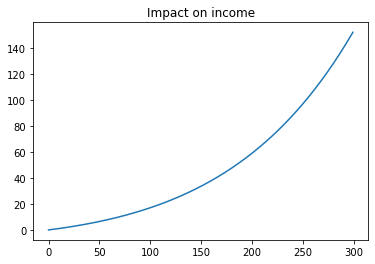

In [23]:
diff = scenario-result 
diff['INCOME'].plot(title='Impact on income');

## But the model instance also contains the results
And they can be used in a more user friendly way

### using the [ ] operator 

We can select the variables of interest with wildcards 

this will operate the results stored in ```basedf``` and ```.lastdf```

#### Look at variables starting with a C 

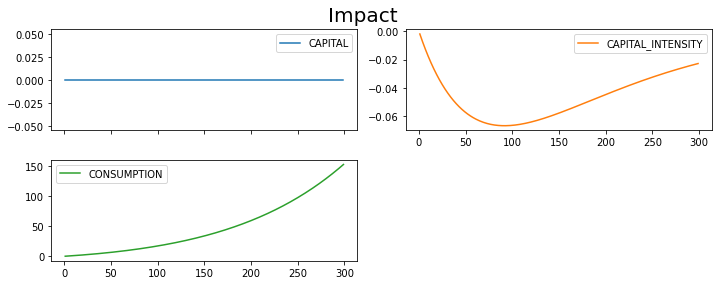

In [24]:
msolow['c*'].dif.plot(title='Impact');

#### Look at all endogenous variables

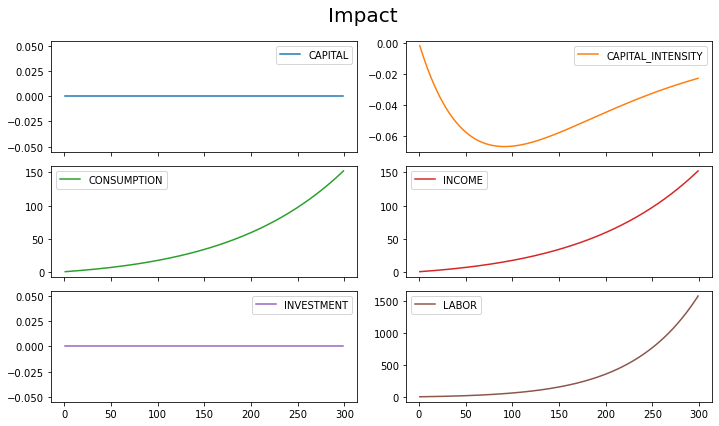

In [25]:
msolow['#ENDO'].dif.plot(sharey=0,title='Impact');

### using the keept solutions 

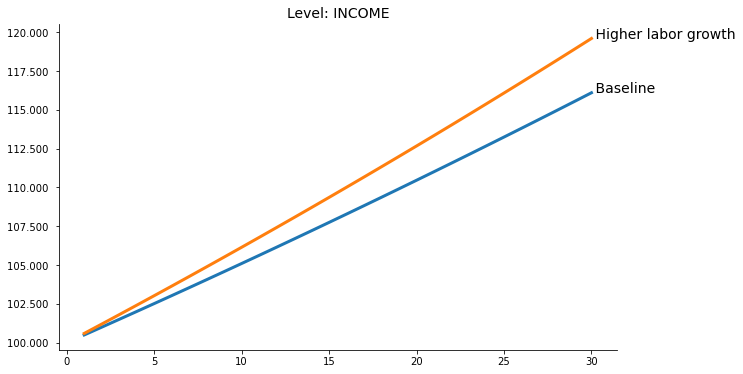

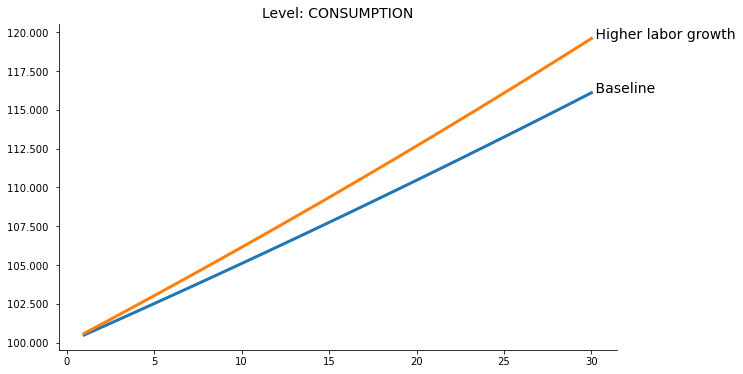

In [26]:
with msolow.set_smpl(1,30):
    msolow.keep_plot('income con*');

## More advanced topics

### The logical stucture 
Now the model has been analyzed, and the structure can be displayed.

You will find more on the logical structure [here](../../howto/structure/Logical_structure.ipynb)

#### Model structure

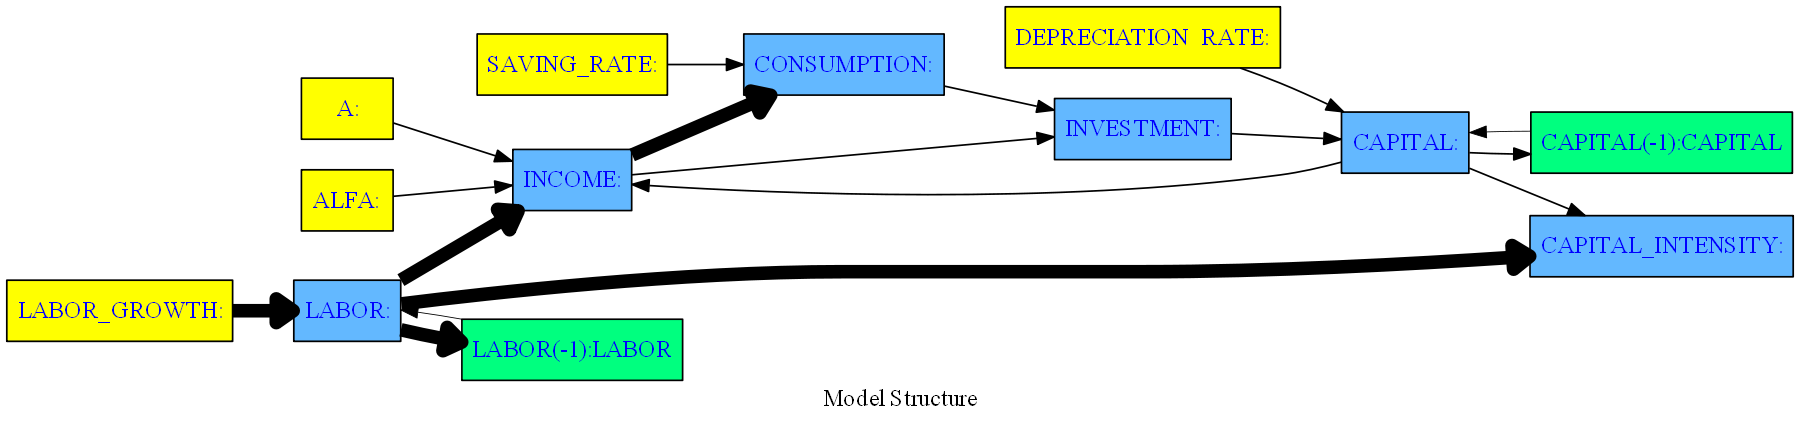

In [27]:
msolow.drawmodel( title="Model Structure", png=latex)

#### Adjacency matrix

Another way to illustrate the dependency graph is an adjacency matrix. 

The variables  ['INVESTMENT', 'CONSUMPTION', 'CAPITAL', 'INCOME'] in the red area are the core of the model and has to be solved as a system. 

LABOR is the prolog and can be calculated before the core is solved. While CAPITAL_INTENSE is the epilog which can be calculated after the core is solved. 

Many models comform to this pattern. And for solving purpose a model is divided into a prolog, core and an epilog. Even if the core is actually consistent of several strong components. 

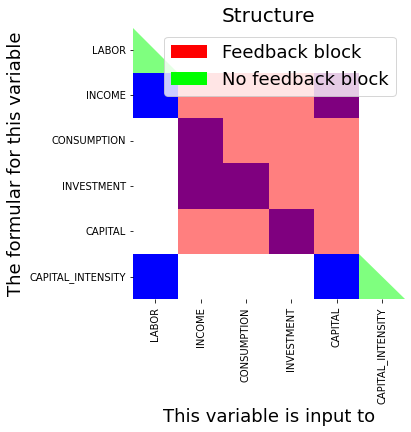

In [28]:
msolow.plotadjacency();

(solow-python-code)=
### The python function used to solve the model. 
Is generated by the transpiler and looks like this 

The user will hopeful  newer have to relate to this code. The point of modelflow is, that the user has to relate to the specification of the business logic, not the implementation in code.   

In [29]:
print(msolow.make_los_text)

def make_los(funks=[],errorfunk=None):
    import time
    import tqdm
    from numba import jit
    from modeluserfunk import jit, recode
    from modelBLfunk import array, classfunk, clognorm, exp, gamma, inspect, jit, lifetime_credit_loss, log, logit, logit_inverse, lognorm, matrix, mv_opt, mv_opt_prop, norm, normcdf, qgamma, sqrt, sum_excel, transpose
    def prolog0(values,outvalues,row,alfa=1.0):
        try :
            pass
            values[row,0]=values[row-1,0]+(values[row,5]*values[row-1,0])
        except :
            errorfunk(values,sys.exc_info()[2].tb_lineno,overhead=9,overeq=0)
            raise
        return 
    def prolog(values,outvalues,row,alfa=1.0):
        prolog0(values,outvalues,row,alfa=alfa)
        return  
    def core0(values,outvalues,row,alfa=1.0):
        try :
            pass
            values[row,7]=values[row,3]*values[row,1]**values[row,2]*values[row,0]**(1-values[row,2])
            values[row,8]=(1-values[row,9])*values[row,7]
           